# Background

I performed some basic survival analysis in Stata and shared the log file with ChatGPT. My request? Reproduce it in Python. And here is the response:

```stata
//yours truly
capture log close 
log using stata2py.log,replace 
import delimited "ds4ph.capstone.csv", clear
describe
g years=permth_int/12
g died=mortstat=="Assumed deceased"
stset years,fail(died)
sts graph, fail
encode race, gen(racecat)
stcox age female i.racecat dm htn acr hba1c egfr sbp 
log close 
```

Some great [Stata-to-Python](https://www.danielmsullivan.com/pages/tutorial_stata_to_python.html) code

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%   
covariate                                                                  
age        0.085383   1.089134  0.000594        0.084220        0.086547  \
female    -0.355030   0.701153  0.016128       -0.386639       -0.323420   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to           z   
covariate                                                                 
age                   1.087868             1.090402     0.0  143.829280  \
female                0.679336             0.723670     0.0  -22.013754   

                       p    -log2(p)  
covariate                             
age         0.000000e+00         inf  
female     2.126362e-107  354.357919  


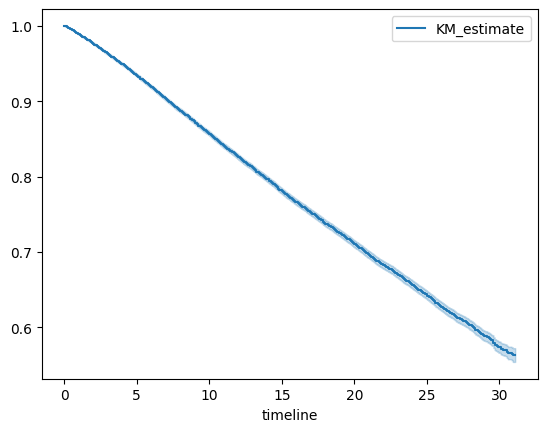

In [154]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Import the CSV file
data = pd.read_csv('ds4ph.capstone.csv')

# Create Kaplan-Meier survival curves
kmf = KaplanMeierFitter()

# Define the survival time and event columns
time_column = 'years'  # Replace with the actual column name in your CSV
event_column = 'died'  # Replace with the actual column name in your CSV

# Fit the Kaplan-Meier estimator
kmf.fit(data[time_column], data[event_column])

# Plot the survival curves
kmf.plot()

# Perform Cox regression
cph = CoxPHFitter()

# Define the covariate columns
covariates = ['age', 'female']  # Replace with the actual column names in your CSV

# Fit the Cox regression model
cph.fit(data, duration_col=time_column, event_col=event_column, formula='age + female ')


# Print the summary
print(cph.summary)


In [155]:

# Filter observations with missing data
# df_missing = df[df.isnull().any(axis=1)]

# Tabulate summary by survey
# summary_table = df_missing.groupby('year').size()
# print(summary_table)


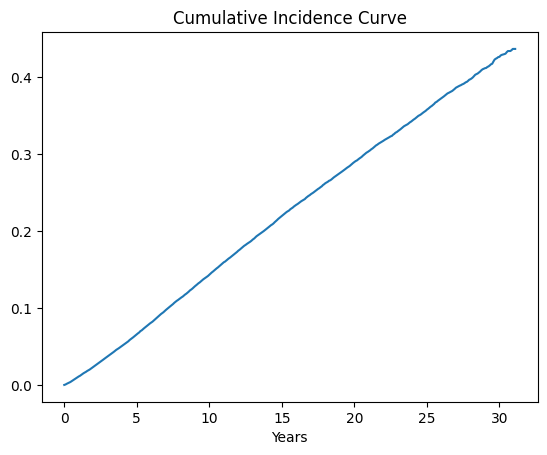

(73538, 4)

In [156]:

# Kaplan-Meier plot
kmf = ll.KaplanMeierFitter()
kmf.fit(df['years'], event_observed=df['died'])

# Complementary cumulative incidence (1 - Kaplan-Meier estimate)
ci = 1 - kmf.survival_function_

# Plotting
plt.plot(ci.index, ci['KM_estimate'])
plt.xlabel("Years")
plt.ylabel("")
plt.title("Cumulative Incidence Curve")

# Add the risk table
# risk_table = kmf.event_table
# plt.table(cellText=risk_table.values, colLabels=risk_table.columns, loc='center', cellLoc='center')

plt.show()
df.shape

# app

In [157]:


# Load and preprocess the NHANES dataset

# Perform necessary preprocessing steps on the dataset
# ...

# Split the dataset into training and testing sets

# Split the dataset into features (X) and the target variable (y)
X = data[['age', 'female']]

# X = df[['age', 'sex', 'race', 'diabetes', 'hypertension', 'kidney_disease', 'smoking', 'medication',
# 'bmi', 'sbp', 'creatinine', 'albumin_creatinine_ratio', 'egfr', 'hba1c']]
y = data['years']

# Train a Cox proportional hazards regression model
cph = CoxPHFitter()
cph.fit(X, duration_col='years', event_col='died')

# Extract the beta coefficients
betas = cph.summary['coef'].values

# Save the trained model and beta coefficients
with open('model.pkl', 'wb') as file:
    pickle.dump(cph, file)

with open('betas.pkl', 'wb') as file:
    pickle.dump(betas, file)


KeyError: 'years'

Here is a basic implementation of a Streamlit app called capstone.py that produces a calculator to estimate the 30-year risk of mortality in healthy living kidney donor candidates:

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load the model and beta coefficients
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)
    
with open('betas.pkl', 'rb') as file:
    betas = pickle.load(file)

# Define a function to calculate the risk of mortality
def calculate_risk(demographic, history, exam, labs):
    # Combine all input features into a single array
    features = np.concatenate([demographic, history, exam, labs])
    
    # Calculate the log hazard ratio using the beta coefficients
    log_hr = np.sum(features * betas)
    
    # Calculate the absolute risk using the Cox proportional hazards formula
    risk = np.exp(log_hr) * baseline_risk
    
    return risk

# Define the baseline risk for a healthy individual
baseline_risk = 0.0028

# Define the input fields for the calculator
age = st.slider('Age', 18, 100, 30)
sex = st.selectbox('Sex', ['Male', 'Female'])
race = st.selectbox('Race', ['White', 'Black', 'Other'])
diabetes = st.checkbox('Diabetes')
hypertension = st.checkbox('Hypertension')
kidney_disease = st.checkbox('Kidney Disease')
smoking = st.checkbox('Smoking')
medication = st.checkbox('Taking Medication')
bmi = st.slider('BMI', 10, 60, 20)
sbp = st.slider('SBP', 50, 250, 120)
creatinine = st.slider('Serum Creatinine', 0.1, 5.0, 1.0)
albumin_creatinine_ratio = st.slider('Urine Albumin-to-Creatinine Ratio', 0.0, 100.0, 0.0)
egfr = st.slider('eGFR', 0, 200, 100)
hba1c = st.slider('HbA1c', 0.0, 20.0, 5.0)

# Convert categorical variables to one-hot encoding
if sex == 'Male':
    sex_male = 1
else:
    sex_male = 0
    
if race == 'White':
    race_white = 1
    race_black = 0
    race_other = 0
elif race == 'Black':
    race_white = 0
    race_black = 1
    race_other = 0
else:
    race_white = 0
    race_black = 0
    race_other = 1

# Combine all input features into a single array
demographic = np.array([age, sex_male, race_white, race_black, race_other])
history = np.array([int(diabetes), int(hypertension), int(kidney_disease), int(smoking), int(medication)])
exam = np.array([bmi, sbp])
labs = np.array([creatinine, albumin_creatinine_ratio, egfr, hba1c])

# Calculate the risk of mortality using the input features
risk = calculate_risk(demographic, history, exam, labs)

# Display the calculated risk
st.write('30-Year Risk of Mortality:', risk)


Note that the implementation assumes that you have already trained a Cox proportional hazards regression model using the NHANES data and saved it as a pickled file called
model.pkl, and also saved the beta coefficients as a pickled file called betas.pkl. You will need to replace the file names and paths in the with open() statements to match your specific implementation.

Also, please note that this is a basic implementation and may require additional modifications to meet your specific requirements.